#Sentiment analysis, classifying reviews as positive, negative, or neutral. Statistical analysis will be conducted to identify potential differences in sentiment across neighborhoods.

# Data
### Seattle Airbnb Open Data
Datasets used: http://insideairbnb.com/get-the-data/

## Table of Content

- Getting Started, importing and understanding data
- Data Preprocessing and Preparation, cleaning data, Feature Engineering
- Unsupervised Sentiment Analysis
- Sentiment Prediction using Vader
- Visulization and Insights


# Getting Started

In [2]:
pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00


In [3]:
from datetime import datetime, date
import numpy as np
import pandas as pd

#For sentiment Analysis
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# For text analysis and categorizing
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# For visualization
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Setting colab table display options

In [4]:
# Set the width of the display in characters
pd.set_option('display.width', 1000)

# Set the maximum number of columns to be displayed
#pd.set_option('max_columns', 500)

# Set the maximum number of rows to be displayed
#pd.set_option('display.max_rows', 500)


## Gather: Import Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
calendar = pd.read_csv('/content/drive/MyDrive/Extras/London/calendar.csv')
listings = pd.read_csv('/content/drive/MyDrive/Extras/London/listings.csv')
rev = pd.read_csv('/content/drive/MyDrive/Extras/London/reviews.csv')

#Reducing dataset to 5% randomly
reviews = rev.sample(frac=0.01)


In [7]:

print(listings.shape)
listings.sample(2)

(81791, 75)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
14929,16616496,https://www.airbnb.com/rooms/16616496,20230608145305,2023-06-10,previous scrape,Rental unit in London · 1 bedroom · 1 bed · 1 ...,"My place is close to Battersea park, The Latch...",NaN,https://a0.muscache.com/pictures/dba7daf8-bcc3...,20714888,...,NaN,NaN,NaN,NaN,t,1,0,1,0,NaN
38549,40544369,https://www.airbnb.com/rooms/40544369,20230608145305,2023-06-09,previous scrape,Rental unit in Greater London · 1 bedroom · 1 ...,Cozy double bed room in Central london,NaN,https://a0.muscache.com/pictures/f43a73c9-939d...,304651366,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN


In [8]:
print(reviews.shape)
reviews.head()

(14675, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
231437,5206665,357043601,2018-12-09,217937470,Francisco Julian,Very good value for money
554001,16767973,478733856,2019-06-30,25400080,Rodrigo,"Everything went well. Room was very comfy, and..."
1454166,839806695761440457,870916734387312852,2023-04-16,417206092,Lilli,Great for large families
292437,7380225,342130494,2018-10-28,65951961,Virginia,"Nice Place, Nice People! Great time in London!..."
1254785,53422816,735315653813890925,2022-10-11,217266,Mason,Charming flat and welcoming hosts!<br/>Thank y...


In [9]:
print(calendar.shape)
calendar.head()

(29853384, 7)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,13913,2023-06-09,f,$79.00,$79.00,1.0,29.0
1,13913,2023-06-10,f,$79.00,$79.00,1.0,29.0
2,13913,2023-06-11,f,$79.00,$79.00,1.0,29.0
3,13913,2023-06-12,t,$79.00,$79.00,1.0,29.0
4,13913,2023-06-13,t,$79.00,$79.00,1.0,29.0


# Data Preprocessing and Preparation, Cleaing data, Feature Engineering


### 1. Convert strings of true, false to 1 and 0 in specific columns

In [10]:
def convert_tf(df, columns, true_value = 't'):
    """
    Convert specified columns of a dataframe from String values representing
    true or false (default: 't' for true) to integers 1 and 0.

    Parameters:
    - df: Dataframe with columns to convert
    - columns: List of column names to convert
    - true_value: The string value in the dataframe that represents 'true'. Default is 't'.
    """

    # Loop through each column specified
    for c in columns:
        # For each value in the column, check if it matches the 'true_value'.
        # If it does, replace with 1, otherwise replace with 0.
        df[c] = [1 if i==true_value else 0 for i in df[c]]


In [11]:
convert_tf(listings, ['host_is_superhost', 'has_availability', 'instant_bookable'],
          't')

In [12]:
convert_tf(calendar, ['available'], 't')

### 2. Conver the price and extra fee column to numeric

In [13]:
def convert_str_to_num(df, columns):
    for col in columns:
        # Convert the entire column to string
        df[col] = df[col].astype(str)

        # Remove $ and , from the price column
        df[col] = df[col].str.replace('$', '').str.replace(',', '')

        # Convert empty strings to NaN
        df[col] = df[col].replace('', pd.NA)

        # Convert to numeric, coercing any errors
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

# Usage
calendar = convert_str_to_num(calendar, ['price'])



<ipython-input-13-7b43be5d45e0>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('$', '').str.replace(',', '')


In [14]:
convert_str_to_num(listings, ['price'])

<ipython-input-13-7b43be5d45e0>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('$', '').str.replace(',', '')


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,154221,https://www.airbnb.com/rooms/154221,20230608145305,2023-06-10,previous scrape,Rental unit in London · 2 bedrooms · 2 beds · ...,"hi, i am renting my 2 bedroom flat in Pimlico ...","a very save area of central London , Pimlico i...",https://a0.muscache.com/pictures/3510524/72655...,211018,...,5.00,5.00,5.00,NaN,0,1,1,0,0,0.01
1,157714,https://www.airbnb.com/rooms/157714,20230608145305,2023-06-09,city scrape,Townhouse in Hammersmith · ★4.71 · 1 bedroom ·...,"Large, light and spacious loft bedroom with a ...",The neighbourhood is extremely convenient for ...,https://a0.muscache.com/pictures/4129744/10db5...,757377,...,4.83,4.76,4.66,NaN,0,1,0,1,0,1.21
2,13913,https://www.airbnb.com/rooms/13913,20230608145305,2023-06-09,city scrape,Rental unit in Islington · ★4.80 · 1 bedroom ·...,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,...,4.82,4.69,4.69,NaN,0,2,1,1,0,0.26
3,15400,https://www.airbnb.com/rooms/15400,20230608145305,2023-06-09,city scrape,Rental unit in London · ★4.80 · 1 bedroom · 1 ...,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,...,4.83,4.93,4.74,NaN,0,1,1,0,0,0.57
4,306333,https://www.airbnb.com/rooms/306333,20230608145305,2023-06-09,city scrape,Rental unit in London · ★4.32 · 2 bedrooms · 3...,Welcome to my lovely 2-bedroom flat in Hoxton!...,"In Shoreditch, empty walls are future murals. ...",https://a0.muscache.com/pictures/32c818d1-7762...,1573870,...,4.84,4.89,4.53,NaN,0,1,1,0,0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81786,908448542533162051,https://www.airbnb.com/rooms/908448542533162051,20230608145305,2023-06-10,city scrape,Rental unit in Greater London · ★New · 1 bedro...,Show up and start living from day one in Londo...,"With leafy, green pathways and large, lavish m...",https://a0.muscache.com/pictures/prohost-api/H...,314162972,...,NaN,NaN,NaN,NaN,0,280,280,0,0,NaN
81787,908448851903630292,https://www.airbnb.com/rooms/908448851903630292,20230608145305,2023-06-09,city scrape,Rental unit in Greater London · ★New · 2 bedro...,Show up and start living from day one in Londo...,Hailed for its iconic cultural attractions lik...,https://a0.muscache.com/pictures/prohost-api/H...,314162972,...,NaN,NaN,NaN,NaN,0,280,280,0,0,NaN
81788,908450386316337239,https://www.airbnb.com/rooms/908450386316337239,20230608145305,2023-06-09,city scrape,Rental unit in Greater London · ★New · 1 bedro...,Spacious flat in Stokey 5 minute walk from Hac...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,36404387,...,NaN,NaN,NaN,NaN,0,1,0,1,0,NaN
81789,908452889848079702,https://www.airbnb.com/rooms/908452889848079702,20230608145305,2023-06-09,city scrape,Rental unit in Greater London · ★New · 3 bedro...,The whole group will enjoy easy access to ever...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,518621554,...,NaN,NaN,NaN,NaN,1,2,2,0,0,NaN


In [15]:
convert_str_to_num(calendar, ['price'])

<ipython-input-13-7b43be5d45e0>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('$', '').str.replace(',', '')


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,13913,2023-06-09,0,79.0,$79.00,1.0,29.0
1,13913,2023-06-10,0,79.0,$79.00,1.0,29.0
2,13913,2023-06-11,0,79.0,$79.00,1.0,29.0
3,13913,2023-06-12,1,79.0,$79.00,1.0,29.0
4,13913,2023-06-13,1,79.0,$79.00,1.0,29.0
...,...,...,...,...,...,...,...
29853379,909281506879757665,2024-06-03,0,135.0,$135.00,21.0,181.0
29853380,909281506879757665,2024-06-04,0,135.0,$135.00,21.0,180.0
29853381,909281506879757665,2024-06-05,0,135.0,$135.00,21.0,179.0
29853382,909281506879757665,2024-06-06,0,135.0,$135.00,21.0,178.0


In [16]:
calendar['price'].head(2)

0    79.0
1    79.0
Name: price, dtype: float64

In [17]:
listings['price'].head(2)

0    83.0
1    69.0
Name: price, dtype: float64

### 3. Create calendar_df: group by the listing and check the average price of each listing
- we probably don't need daily price information in this analysis

In [18]:
calendar_df = calendar[calendar['available']== True].groupby('listing_id')['price'].mean().reset_index()

In [19]:
calendar_df.sample(5)

,listing_id,price
38362,785293772928070863,69.000000
13295,34963590,530.526316
10735,28429044,276.406250
31012,683873907171086275,87.947368
15301,39396216,182.924138


### 4. Drop some uneeded columns in the listing datasets, mostly website URLs

In [20]:
#Dropping some of unwanted columns from listings dataset
listings = listings.drop([ 'host_thumbnail_url', 'host_picture_url', 'host_url', 'picture_url', 'listing_url',
                         'scrape_id', 'last_scraped', 'name', 'host_id', 'host_name','calendar_last_scraped' ]  , axis=1)

In [21]:
listings.head(2)

,id,source,description,neighborhood_overview,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,154221,previous scrape,"hi, i am renting my 2 bedroom flat in Pimlico ...","a very save area of central London , Pimlico i...",2010-08-24,"Rome, Italy",i love to travel and therefor want to give my ...,NaN,NaN,NaN,...,5.00,5.00,5.00,NaN,0,1,1,0,0,0.01
1,157714,city scrape,"Large, light and spacious loft bedroom with a ...",The neighbourhood is extremely convenient for ...,2011-06-29,"London, United Kingdom","Eilinn, Yoon our daughters Surei and Sukyi wou...",within a few hours,90%,68%,...,4.83,4.76,4.66,NaN,0,1,0,1,0,1.21


### 5. Convert "host_since" column into a number instead of a date
We can utlize hosts' years of experience as a potential feature

In [22]:
# Convert the 'host_since' column of the 'listings' DataFrame from a string format to a datetime format.
# This allows for more efficient and accurate date-time operations on this column.
listings['host_since'] = pd.to_datetime(listings['host_since'])


In [23]:
# Know the last date of this data sets so that we have an end date to calculate days of experience
date_end = calendar['date'].max()
print(date_end)

2024-06-10


In [24]:
# Calculate the experience of the host in terms of days.
# Subtract the 'host_since' date from a specified end date ('date_end') to get the duration of host experience.
listings['host_exp_days']  = (datetime.strptime(date_end, '%Y-%m-%d') - listings['host_since'])

# Convert the timedelta object (which represents the difference between two dates)
# to an integer representing the number of days. This creates a new column 'host_exp_days'
# that stores the experience of each host in days.
listings['host_exp_days'] = listings['host_exp_days'].dt.days


In [25]:
listings['host_exp_days'].head()

0    5039.0
1    4730.0
2    5320.0
3    5301.0
4    4539.0
Name: host_exp_days, dtype: float64

### 6. Create another column that shows hosts' experience in number of years

In [26]:
#Creating a column that shows host experience
listings['host_exp_year']=listings['host_exp_days']/365

In [27]:
listings['host_exp_year']

0        13.805479
1        12.958904
2        14.575342
3        14.523288
4        12.435616
           ...    
81786     4.523288
81787     4.523288
81788     8.975342
81789     1.013699
81790     1.263014
Name: host_exp_year, Length: 81791, dtype: float64

### 7. Convert "host_since" column into a number instead of a date
We can utlize hosts' years of experience as a potential feature

In [28]:
listings[['host_response_rate', 'host_acceptance_rate']].head()

,host_response_rate,host_acceptance_rate
0,NaN,NaN
1,90%,68%
2,100%,78%
3,100%,47%
4,100%,100%


In [29]:
def convert_str_to_num(df, column_list):
    """
    Converts specified columns of a DataFrame from a string format with dollar signs and commas
    (e.g., "$1,000") to a numeric format (e.g., 1000.0).

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the columns to be converted.
    - column_list (list): List of column names that need conversion.

    Returns:
    None. The function modifies the input DataFrame in-place.
    """

    for c in column_list:
        # For each specified column:
        # 1. Remove dollar signs, commas, and spaces.
        # 2. Convert the cleaned string to a floating point number.
        df[c] = df[c].str.replace("[$, ]", "").astype("float")


def convert_rate_col(df, columns):
    """
    Converts specified columns of a DataFrame from a percentage string format (e.g., "100%")
    to a decimal format float (e.g., 1.00).

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the columns to be converted.
    - columns (list): List of column names that need conversion from percentage strings to floats.

    Returns:
    None. The function modifies the input DataFrame in-place.
    """

    for column in columns:
        # Check if the column contains string values
        if df[column].dtype == 'object':
            # Remove the percentage sign from the values in the column.
            df[column] = df[column].str.replace("%", "").astype("float")

            # Convert the percentage value to a decimal by dividing by 100.
            df[column] = df[column] / 100
        else:
            print(f"Column '{column}' does not contain string values and was skipped.")


In [30]:
#Applying above Function to slected columns in Listings dataset
convert_rate_col(listings, ['host_response_rate', 'host_acceptance_rate'])

In [31]:
listings[['host_response_rate', 'host_acceptance_rate']].head()

,host_response_rate,host_acceptance_rate
0,NaN,NaN
1,0.9,0.68
2,1.0,0.78
3,1.0,0.47
4,1.0,1.00


# Missing Data

### Check missing data

In [32]:
np.sum(listings.isnull())==0

id                                               True
source                                           True
description                                     False
neighborhood_overview                           False
host_since                                      False
                                                ...  
calculated_host_listings_count_private_rooms     True
calculated_host_listings_count_shared_rooms      True
reviews_per_month                               False
host_exp_days                                   False
host_exp_year                                   False
Length: 66, dtype: bool

In [33]:
np.sum(reviews.isnull())==0

listing_id       True
id               True
date             True
reviewer_id      True
reviewer_name    True
comments         True
dtype: bool

In [34]:
np.sum(calendar.isnull())==0

listing_id         True
date               True
available          True
price             False
adjusted_price    False
minimum_nights    False
maximum_nights    False
dtype: bool

# Unsupervised Sentiment Prediction & Analysis

### 1. Drop the rows with missing comments in the reviews data

In [35]:
reviews = reviews.dropna(subset=['comments'])

In [36]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
231437,5206665,357043601,2018-12-09,217937470,Francisco Julian,Very good value for money
554001,16767973,478733856,2019-06-30,25400080,Rodrigo,"Everything went well. Room was very comfy, and..."
1454166,839806695761440457,870916734387312852,2023-04-16,417206092,Lilli,Great for large families
292437,7380225,342130494,2018-10-28,65951961,Virginia,"Nice Place, Nice People! Great time in London!..."
1254785,53422816,735315653813890925,2022-10-11,217266,Mason,Charming flat and welcoming hosts!<br/>Thank y...


# Sentiment Prediction using Vader
#### Getting a predicted sentiment compound scores using Vader Sentiment Intensity Analyzer and add it as a column

In [37]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Instantiate the Sentiment Intensity Analyzer
analyser = SentimentIntensityAnalyzer()

# Define a lambda function that will apply the sentiment analysis to the title and return the compound score
# The 'compound' score is a metric that calculates the sum of all the lexicon ratings and normalizes them between -1 (most extreme negative) and +1 (most extreme positive).
# Positive values > 0 indicate positive sentiment, values < 0 indicate negative sentiment.
function = lambda title: analyser.polarity_scores(title)['compound']

# Apply the function to the 'comments' column of the 'reviews' DataFrame to get the sentiment scores
# Save the sentiment scores in a new column named 'compound' in the 'reviews' DataFrame
reviews['compound'] = reviews['comments'].apply(function)


In [38]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,compound
231437,5206665,357043601,2018-12-09,217937470,Francisco Julian,Very good value for money,0.7070
554001,16767973,478733856,2019-06-30,25400080,Rodrigo,"Everything went well. Room was very comfy, and...",0.7096
1454166,839806695761440457,870916734387312852,2023-04-16,417206092,Lilli,Great for large families,0.6249
292437,7380225,342130494,2018-10-28,65951961,Virginia,"Nice Place, Nice People! Great time in London!...",0.9411
1254785,53422816,735315653813890925,2022-10-11,217266,Mason,Charming flat and welcoming hosts!<br/>Thank y...,0.9412


### Adding positive scores

In [39]:
# Define a lambda function to apply sentiment analysis to the title and extract the positive sentiment score.
# The 'pos' score represents the proportion of the text that falls into a positive category.
function = lambda title: analyser.polarity_scores(title)['pos']

# Apply the function to the 'comments' column of the 'reviews' DataFrame to obtain the positive sentiment scores.
# Store these scores in a new column named 'positive_score' in the 'reviews' DataFrame.
reviews['positive_score'] = reviews['comments'].apply(function)


In [40]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,compound,positive_score
231437,5206665,357043601,2018-12-09,217937470,Francisco Julian,Very good value for money,0.7070,0.662
554001,16767973,478733856,2019-06-30,25400080,Rodrigo,"Everything went well. Room was very comfy, and...",0.7096,0.219
1454166,839806695761440457,870916734387312852,2023-04-16,417206092,Lilli,Great for large families,0.6249,0.577
292437,7380225,342130494,2018-10-28,65951961,Virginia,"Nice Place, Nice People! Great time in London!...",0.9411,0.711
1254785,53422816,735315653813890925,2022-10-11,217266,Mason,Charming flat and welcoming hosts!<br/>Thank y...,0.9412,0.513


# Rule based Sentiment Classification using the predicted score
### Based on the sentiment score, classify the type of customer review sentiment into positive, negative and neutral


#### About the Scoring
The output from Vader sentiment Analyzer - compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

In [41]:
# Define a function to categorize sentiment based on the compound score.
# - If the compound score is greater than 0.5, the sentiment is categorized as "positive".
# - If the compound score is less than -0.5, the sentiment is categorized as "negative".
# - Otherwise, the sentiment is categorized as "neutral".
def func(x):
    if x > 0.5:
        return "positive"
    elif x < -0.5:
        return "negative"
    else:
        return 'neutral'
    # Add elif statements....

# Apply the function to the 'compound' column of the 'reviews' DataFrame to categorize each review's sentiment.
# Store the categorized sentiment in a new column named 'sentiment' in the 'reviews' DataFrame.
reviews['sentiment'] = reviews['compound'].apply(func)


In [42]:
def func(x):
    """
    Categorize sentiment based on the compound score.

    Parameters:
    - x (float): Compound sentiment score.

    Returns:
    - int: Returns 1 for positive sentiment, -1 for negative sentiment, and 0 for neutral.
    """

    # If the compound sentiment score is greater than 0.8, classify as positive sentiment.
    if x > 0.8:
        return "postive"
    # If the compound sentiment score is less than -0.5, classify as negative sentiment.
    elif x < -0.5:
        return "negative"
    # For other scores, classify as neutral sentiment.
    else:
        return "neutral"

    # Add more elif statements as needed to refine the sentiment categorization...

# Apply the defined function to each row in the 'compound' column of the 'reviews' DataFrame.
# Store the resultant sentiment categories in a new column named 'sentiment'.
reviews['sentiment_'] = reviews['compound'].apply(func)


In [43]:
reviews.sample(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,compound,positive_score,sentiment,sentiment_
1025145,37000549,722327885,2021-01-06,28334949,Luna,Koysor was a great host. Fast communication an...,0.9456,0.344,positive,postive
1177276,48708553,646949515902227592,2022-06-11,174433645,Stefano,"Overall a nice room, very small tho, in terms ...",0.4215,0.085,neutral,neutral


# Some Data processing again

### Aggregate the review data based on sentiment classification we got above and join it with the listing data sets.

In [44]:
reviews_agg =  reviews.groupby(['listing_id', 'sentiment'])['positive_score', 'compound'].mean().reset_index()

<ipython-input-44-44c1fd0194c0>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  reviews_agg =  reviews.groupby(['listing_id', 'sentiment'])['positive_score', 'compound'].mean().reset_index()


In [45]:
reviews_agg.head()

,listing_id,sentiment,positive_score,compound
0,15400,positive,0.22300,0.949300
1,17402,positive,0.22100,0.948400
2,36299,positive,0.32700,0.807400
3,36660,neutral,0.00000,0.000000
4,36660,positive,0.45325,0.929125


In [46]:
#Merging two dataset
df_all =  pd.merge(listings, reviews, how='inner', left_on=['id'], right_on=['listing_id'])

In [47]:
df_all.head(2)

,id_x,source,description,neighborhood_overview,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,listing_id,id_y,date,reviewer_id,reviewer_name,comments,compound,positive_score,sentiment,sentiment_
0,157714,city scrape,"Large, light and spacious loft bedroom with a ...",The neighbourhood is extremely convenient for ...,2011-06-29,"London, United Kingdom","Eilinn, Yoon our daughters Surei and Sukyi wou...",within a few hours,0.9,0.68,...,157714,165949898,2017-07-02,40191081,Zhao,房东人特别和善，会给很多建议，很感谢她，房间很干净，位置也很好，离地铁站很近，很方便，如果以...,0.0000,0.000,neutral,neutral
1,157714,city scrape,"Large, light and spacious loft bedroom with a ...",The neighbourhood is extremely convenient for ...,2011-06-29,"London, United Kingdom","Eilinn, Yoon our daughters Surei and Sukyi wou...",within a few hours,0.9,0.68,...,157714,2831335,2012-11-07,3939650,Gracja,We did not only feel welcome but at home =). T...,0.9272,0.341,positive,postive


# Visualizations and anwsering business questions

###Do people tend to leave comment about bad reviews or good reviews? Are the sentiment differ from neighbourhoods?

###Creating charts for review distribution for top 5 neighbourhoods


Before creating subplot using plotly, need to pivot the table

In [48]:
df_group = df_all.groupby(['sentiment', 'neighbourhood_cleansed']).size().reset_index().rename(columns={0: 'count_reviews'})

In [49]:
df_group.head()

,sentiment,neighbourhood_cleansed,count_reviews
0,negative,Barking and Dagenham,1
1,negative,Barnet,3
2,negative,Bexley,2
3,negative,Brent,11
4,negative,Bromley,5


In [50]:
df_top_neighbour_list= df_group.groupby(['neighbourhood_cleansed' ])['count_reviews'].sum().sort_values(ascending = False).reset_index().iloc[:5, 0].unique().tolist()

In [51]:
df_top_neighbour_list

['Westminster',
 'Camden',
 'Tower Hamlets',
 'Southwark',
 'Kensington and Chelsea']

In [52]:
df_top_neighbour = df_group[df_group['neighbourhood_cleansed'].isin(df_top_neighbour_list)]

df_top_neighbour [df_top_neighbour ['neighbourhood_cleansed']=='Capitol Hill']

# pivot the table
pf = df_top_neighbour .pivot_table(values='count_reviews', index=['sentiment'],
               columns='neighbourhood_cleansed', aggfunc='sum').reset_index('sentiment')
pf.head()

neighbourhood_cleansed,sentiment,Camden,Kensington and Chelsea,Southwark,Tower Hamlets,Westminster
0,negative,37,22,32,27,48
1,neutral,239,147,176,205,366
2,positive,1041,768,795,905,1491


In [53]:
pf.tail(5)

neighbourhood_cleansed,sentiment,Camden,Kensington and Chelsea,Southwark,Tower Hamlets,Westminster
0,negative,37,22,32,27,48
1,neutral,239,147,176,205,366
2,positive,1041,768,795,905,1491


###Plot the Positive Sentiment Score per neighbouhood

Function to group the dataframe by some columns and perform different aggregation fuctions based on the metrics and rename the columns

In [54]:
def group_by_multiple(df, columns, count_col, sum_col, mean_col):
    """
    Group the dataframe by some columns and perform different aggregation functions
    based on the metrics and rename the columns.

    Parameters:
    - df: The dataframe to be grouped.
    - columns: List of columns to group by.
    - count_col: The column on which 'count' operation will be performed.
    - sum_col: The column on which 'sum' operation will be performed.
    - mean_col: The column on which 'mean' operation will be performed.

    Returns:
    - result: A dataframe with grouped data and aggregated values.
    """

    # Group by the specified columns and perform count, sum, and mean operations on the respective columns.
    result = df.groupby(columns).agg({
        count_col: 'count',   # Count the number of occurrences
        sum_col: 'sum',       # Sum up the values in the sum_col
        mean_col: 'mean'      # Calculate the average of the mean_col
    }).rename(columns={      # Rename the columns to make them more descriptive
        count_col: f'{count_col}_count',
        sum_col: f'{sum_col}_sum',
        mean_col: f'{mean_col}_mean'
    }).reset_index()         # Reset the index for the result dataframe

    return result

In [55]:
df_all.head(2)

,id_x,source,description,neighborhood_overview,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,listing_id,id_y,date,reviewer_id,reviewer_name,comments,compound,positive_score,sentiment,sentiment_
0,157714,city scrape,"Large, light and spacious loft bedroom with a ...",The neighbourhood is extremely convenient for ...,2011-06-29,"London, United Kingdom","Eilinn, Yoon our daughters Surei and Sukyi wou...",within a few hours,0.9,0.68,...,157714,165949898,2017-07-02,40191081,Zhao,房东人特别和善，会给很多建议，很感谢她，房间很干净，位置也很好，离地铁站很近，很方便，如果以...,0.0000,0.000,neutral,neutral
1,157714,city scrape,"Large, light and spacious loft bedroom with a ...",The neighbourhood is extremely convenient for ...,2011-06-29,"London, United Kingdom","Eilinn, Yoon our daughters Surei and Sukyi wou...",within a few hours,0.9,0.68,...,157714,2831335,2012-11-07,3939650,Gracja,We did not only feel welcome but at home =). T...,0.9272,0.341,positive,postive


In [56]:
# Using the `group_by_multiple` function, we're aggregating data in the 'df_all' DataFrame based on 'neighbourhood'.
# - For the 'id_x' column, we're counting occurrences (likely representing the number of listings in that neighbourhood).
# - For the 'reviews_per_month' column, we're calculating the sum (total number of reviews per month for that neighbourhood).
# - For the 'positive_score' column, we're calculating the average score (mean positive sentiment for reviews in that neighbourhood).
df_pos_review_agg = group_by_multiple(df_all, ['neighbourhood_cleansed'], 'id_x', 'reviews_per_month', 'positive_score')

In [57]:
df_pos_review_agg.head()

,neighbourhood_cleansed,id_x_count,reviews_per_month_sum,positive_score_mean
0,Barking and Dagenham,65,99.98,0.345415
1,Barnet,241,384.22,0.336676
2,Bexley,38,85.67,0.320632
3,Brent,424,810.01,0.303651
4,Bromley,94,144.45,0.322596


In [58]:
df_pos_review_agg.sort_values('id_x_count', ascending = True).head()

,neighbourhood_cleansed,id_x_count,reviews_per_month_sum,positive_score_mean
15,Havering,34,56.73,0.392500
2,Bexley,38,85.67,0.320632
0,Barking and Dagenham,65,99.98,0.345415
14,Harrow,66,97.73,0.362667
28,Sutton,73,124.28,0.351671


In [59]:
# Create a bar chart using Plotly Express:
# - First, sort the 'df_pos_review_agg' DataFrame by the 'id_x_count' column in ascending order.
# - The x-axis will represent the 'neighbourhood_cleansed' column.
# - The height of the bars will represent the 'id_x_count' column.
# - The color of the bars will be determined by the 'positive_score_mean' column.
# - The bar chart will visualize the number of Airbnb reviews by London neighbourhoods with color indicating the positive sentiment score.
fig = px.bar(
    df_pos_review_agg.sort_values('id_x_count', ascending=True),   # DataFrame sorted by 'id_x_count'.
    x='neighbourhood_cleansed',                                    # x-axis column.
    y='id_x_count',                                                # y-axis column (height of bars).
    color='positive_score_mean',                                   # Color scale based on this column.
    title="Number of Airbnb reviews and Positive Sentiment Score Color Scale by London Neighbourhood",
    height=500,                                                    # Set figure height.
    width=1400,                                                    # Set figure width.
    template='plotly_white',                                       # Set figure template to 'plotly_white'.
    color_discrete_sequence=px.colors.qualitative.Set2             # Set custom color sequence.
)

# Update the layout of the figure:
# - Set custom titles for the x and y axes.
# - Define font settings for the figure.
fig.update_layout(
    xaxis_title="Neighbourhood",          # Title for the x-axis.
    yaxis_title="Positive Sentiment Score",   # Title for the y-axis.
    font=dict(family="Avenir")            # Set font family for the figure.
)

# Display the bar chart.
fig.show()


#Analyze Sentiment by Neighborhood

In [60]:
# Group by neighborhood and calculate the mean sentiment score

neighborhood_sentiment = df_all.groupby('neighbourhood_cleansed')['compound'].mean().reset_index()

# Rank neighborhoods by mean sentiment score
neighborhood_sentiment = neighborhood_sentiment.sort_values(by='compound', ascending=False)

# Display the top (and bottom) neighborhoods by sentiment
print(neighborhood_sentiment.head())  # Top 5 neighborhoods
print(neighborhood_sentiment.tail())  # Bottom 5 neighborhoods


   neighbourhood_cleansed  compound
26   Richmond upon Thames  0.812837
20   Kingston upon Thames  0.789614
15               Havering  0.787309
1                  Barnet  0.783290
10              Greenwich  0.780134
   neighbourhood_cleansed  compound
3                   Brent  0.686283
5                  Camden  0.684797
32            Westminster  0.677694
4                 Bromley  0.661017
2                  Bexley  0.595134


### Visualize the overall sentiment distribution using a bar chart

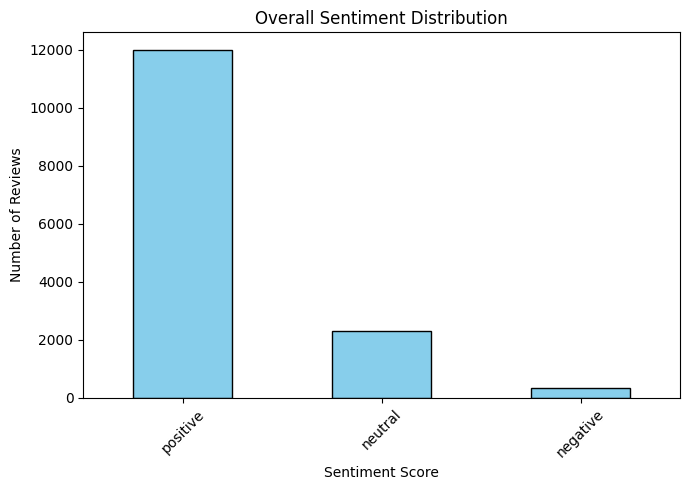

In [61]:
# Calculate the frequency distribution of the 'sentiment' column
sentiment_counts = df_all['sentiment'].value_counts()

plt.figure(figsize=(7,5))
sentiment_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [62]:
neighborhood_sentiment.head()

,neighbourhood_cleansed,compound
26,Richmond upon Thames,0.812837
20,Kingston upon Thames,0.789614
15,Havering,0.787309
1,Barnet,0.783290
10,Greenwich,0.780134


### Visualize the sentiment distribution across neighborhoods using a bar chart

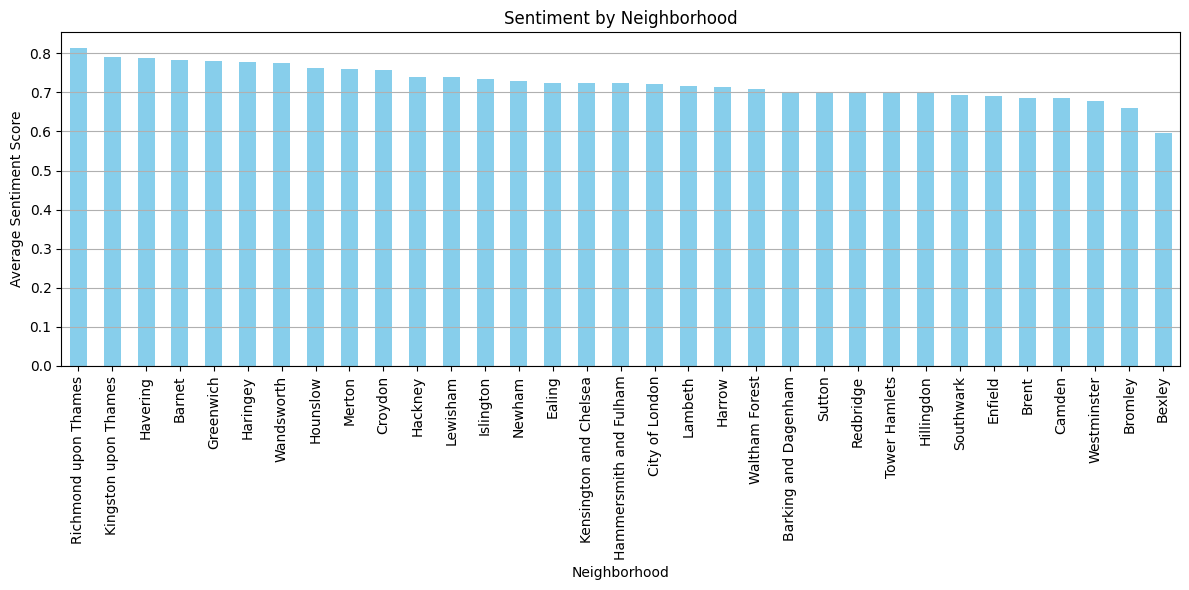

In [63]:
plt.figure(figsize=(12, 6))
neighborhood_sentiment.set_index('neighbourhood_cleansed')['compound'].plot(kind='bar', color='skyblue')  # Changed 'barh' to 'bar'
plt.title('Sentiment by Neighborhood')
plt.xlabel('Neighborhood')  # Swapped with ylabel
plt.ylabel('Average Sentiment Score')  # Swapped with xlabel
plt.grid(True, axis='y')  # Changed axis from 'x' to 'y'
plt.tight_layout()
plt.show()


###Visualizing with a heatmap

If there are too many neighborhoods, a heatmap might be more appropriate:

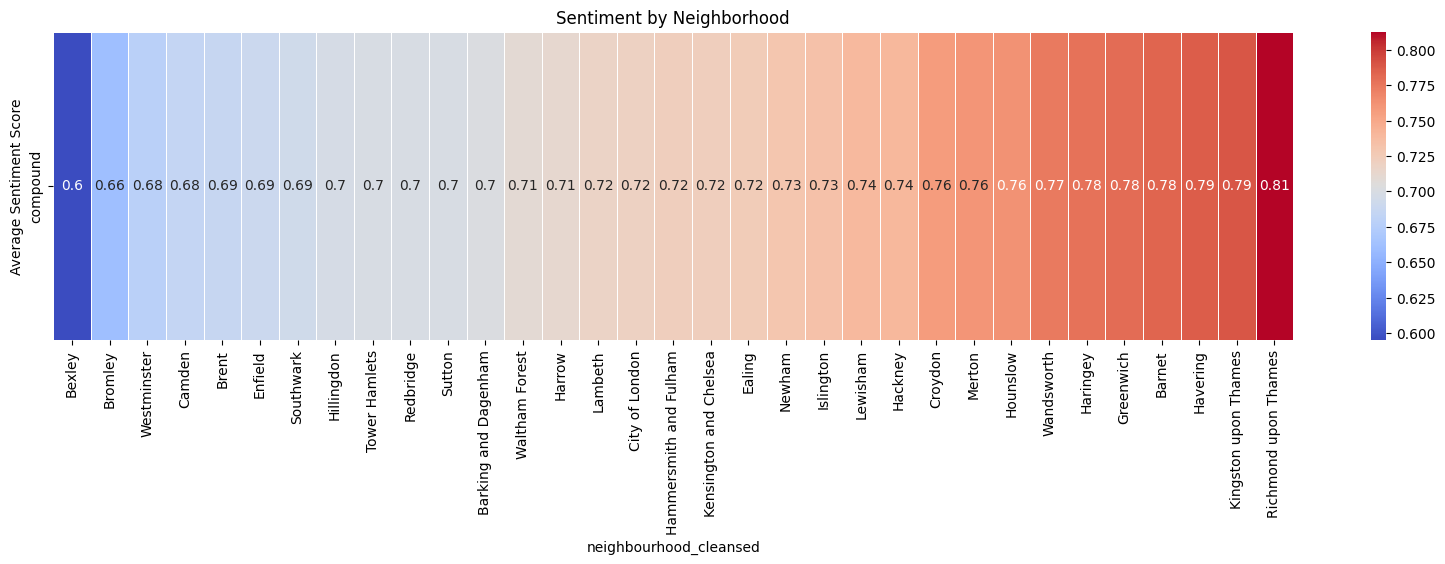

In [64]:
# Ensure the data is sorted for better visualization
neighborhood_sentiment_sorted = neighborhood_sentiment.sort_values(by='compound')

plt.figure(figsize=(20, 4))  # Adjusted figure size for vertical orientation
sns.heatmap(neighborhood_sentiment_sorted.set_index('neighbourhood_cleansed').T, cmap='coolwarm', annot=True, linewidths=0.5)
plt.title('Sentiment by Neighborhood')
plt.ylabel('Average Sentiment Score')  # Adjusted axis label
plt.show()


###Compund Score Histogram

In [65]:
# Group the data by several columns. For each group, compute the mean of several metrics
# (like 'positive_score', 'compound', etc.) and reset the DataFrame's index.
df_listing_agg = df_all.groupby(
    ['neighbourhood_cleansed', 'id_x', 'host_response_time', 'sentiment', 'host_is_superhost', 'property_type', 'room_type']
)['positive_score', 'compound', 'host_exp_days', 'host_exp_year','price', 'host_response_rate', 'host_acceptance_rate', 'review_scores_rating'].mean().reset_index()

# Using Plotly Express, create a histogram visualization for the 'compound' column with 40 bins.
fig = px.histogram(df_listing_agg, x="compound", nbins=40, title="Compound Score Histogram")

# Display the histogram.
fig.show()


<ipython-input-65-034843a1fe57>:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



### Bar plot fot top 5 neighbours

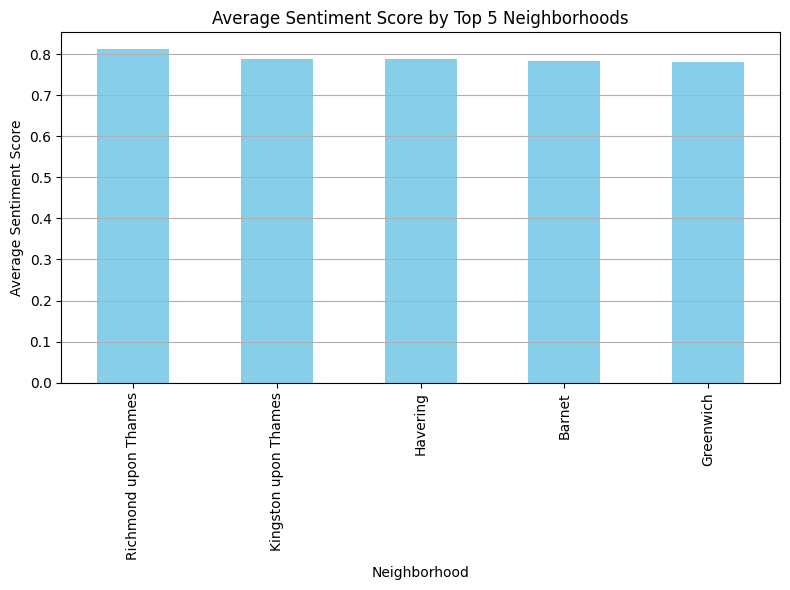

In [66]:
# Calculate mean sentiment for each neighborhood
avg_sentiment = neighborhood_sentiment.groupby('neighbourhood_cleansed')['compound'].mean()

# Sort and get the top 5 neighborhoods
top_5_neighbourhoods = avg_sentiment.nlargest(5)

plt.figure(figsize=(8, 6))
top_5_neighbourhoods.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score by Top 5 Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Average Sentiment Score')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
